In [15]:
import pandas as pd

import statsmodels.formula.api as smf
import statsmodels.api as sm

import matplotlib.pyplot as plt

In [16]:
df_main = pd.read_csv('13to17/table.csv')

df_main.head()

,Unnamed: 0,name,syncs,max_syncs,reads,writes,промахи ср,промахи ди,исп кэша ср,исп кэша ди,промахи L2 ср,промахи L2 ди,исп L2 ср,исп L2 ди,cache_miss_ratio,L2_miss_ratio,nprs_mean,nprs_ci
0,0,1_stock_8192,[0],0,[327680],[172032],4.406040e+07,1.455649e+06,1.001084e+09,5.773847e+06,4.772687e+08,2.556370e+06,5.503901e+08,3.053469e+06,0.044033,0.867159,0.481624,0.003467
1,1,1_depth_8192,[21],21,[327680],[172032],5.626273e+07,1.283400e+06,1.036742e+09,1.250484e+07,4.925319e+08,6.554719e+06,1.003470e+09,1.019483e+07,0.054309,0.490607,0.457993,0.006451
2,2,2_stock_8192,"[2, 2]",2,"[163840, 163840]","[86016, 86016]",3.129924e+07,2.040121e+06,1.958536e+09,1.967624e+07,9.301785e+08,9.865946e+06,1.069672e+09,1.134700e+07,0.016013,0.869592,0.232448,0.003144
3,3,2_depth_8192,"[21, 21]",21,"[163840, 163840]","[86016, 86016]",5.671937e+07,3.579942e+06,1.972877e+09,2.301866e+07,8.048176e+08,1.031118e+07,1.160746e+09,1.375568e+07,0.028887,0.693258,0.362217,0.004662
4,4,4_stock_8192,"[2, 2, 2, 2]",2,"[81920, 81920, 81920, 81920]","[43008, 43008, 43008, 43008]",8.819732e+07,4.980123e+06,2.760119e+09,4.519330e+07,1.298055e+09,2.178905e+07,1.490808e+09,2.481000e+07,0.032072,0.870678,0.159798,0.002608


In [17]:
df = df_main.copy()

# df['cache_miss_ratio'] = df['промахи ср'] / df['исп кэша ср']
# df['L2_miss_ratio'] = df['промахи L2 ср'] / df['исп L2 ср']
df['threads'] = df['reads'].apply(lambda x: len(eval(x)))
df['threads_inverse'] = 1. / df['threads']
df['nprs_mean_inverse'] = 1. / df['nprs_mean']

df = df[['cache_miss_ratio', 'L2_miss_ratio', 'threads_inverse', 'nprs_mean']]

df.head()

,cache_miss_ratio,L2_miss_ratio,threads_inverse,nprs_mean
0,0.044033,0.867159,1.00,0.481624
1,0.054309,0.490607,1.00,0.457993
2,0.016013,0.869592,0.50,0.232448
3,0.028887,0.693258,0.50,0.362217
4,0.032072,0.870678,0.25,0.159798


/tmp/ipykernel_4905/4061128287.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


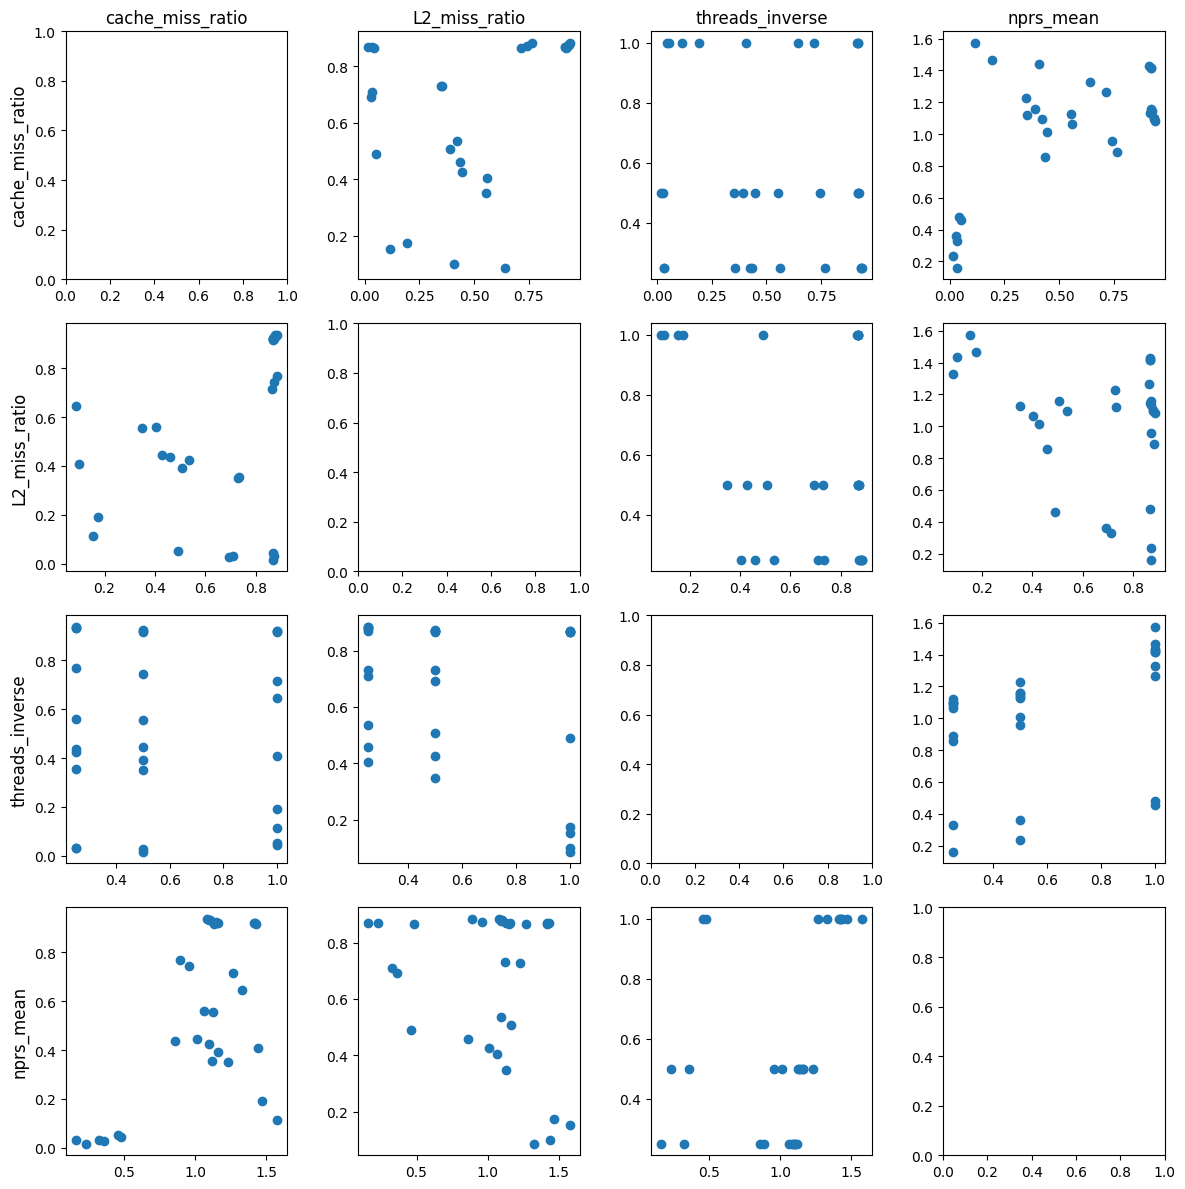

In [35]:
keys = ['cache_miss_ratio', 'L2_miss_ratio', 'threads_inverse', 'nprs_mean']

fig, axes = plt.subplots(len(keys), len(keys), figsize=(12, 12))

for i in range(len(keys)):
    for j in range(len(keys)):
        if i == j:
            continue
        # i_ = i - 1 if i > j else i
        # j_ = j - 1 if j > i else j

        key1 = keys[i]
        key2 = keys[j]

        df.plot(x=key1, y=key2, style='o', ax=axes[i, j], xlabel=None, ylabel=None)
        axes[i, j].get_legend().remove()
        axes[i, j].set_ylabel(None)
        axes[i, j].set_xlabel(None)

for ax, col in zip(axes[0], keys):
    ax.set_title(col)

for ax, row in zip(axes[:,0], keys):
    ax.set_ylabel(row, size='large')

fig.tight_layout()
fig.show()

In [ ]:
df.corr()

,cache_miss_ratio,L2_miss_ratio,threads,threads_inverse,nprs_mean,nprs_mean_inverse
cache_miss_ratio,1.000000,0.376966,0.054144,-0.060648,0.586214,-0.600773
L2_miss_ratio,0.376966,1.000000,0.259012,-0.310102,-0.313354,0.244430
threads,0.054144,0.259012,1.000000,-0.928571,-0.341059,0.229022
threads_inverse,-0.060648,-0.310102,-0.928571,1.000000,0.388458,-0.240158
nprs_mean,0.586214,-0.313354,-0.341059,0.388458,1.000000,-0.859234
nprs_mean_inverse,-0.600773,0.244430,0.229022,-0.240158,-0.859234,1.000000


In [ ]:
model = smf.ols(formula='nprs_mean ~ cache_miss_ratio + L2_miss_ratio + threads_inverse', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              nprs_mean   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     25.08
Date:                Sat, 18 May 2024   Prob (F-statistic):           7.71e-08
Time:                        14:34:20   Log-Likelihood:                 6.6114
No. Observations:                  30   AIC:                            -5.223
Df Residuals:                      26   BIC:                            0.3820
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.8480      0.147  